<a href="https://colab.research.google.com/github/volgasezen/is584/blob/main/Lab 4/Part 3 - GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GloVe

We will now implement Global Vectors for Word Representation (GloVe).  [GloVe project page]( https://nlp.stanford.edu/projects/glove/) introduces GloVe as follows “GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.”

In the previous tutorials, we used pre-trained GloVe word vectors to train our network or see similarities between the words. In this part, we will create our GloVe embeddings while following the process explained in its [paper]( https://nlp.stanford.edu/pubs/glove.pdf).

You can also check [GloVe GitHub page](https://github.com/stanfordnlp/GloVe) for Glove's code implementation.

Let's start with importing the necessary libraries(again).


In [1]:
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE

In [2]:
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

In [3]:
vocab = set(raw_text)
vocab_size = len(vocab)
print(vocab_size)

49


In [5]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}

print('word to ix converts word to numbers: word_to_ix["We"] ->', word_to_ix["We"])
print("ix to word converts word to numbers: ix_to_word[18] ->", ix_to_word[18])

word to ix converts word to numbers: word_to_ix["We"] -> 18
ix to word converts word to numbers: ix_to_word[18] -> We


Now that we imported our libraries and created our text (I suggest trying this model with bigger datasets.), our next step is to create `co-occurrence matrix. As you know, the GloVe model leverages this matrix to find semantic relationships between words.  

To get further information about GloVe, I suggest you to read [this article]( https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010)


In [6]:
ix_tokens = [word_to_ix[w] for w in raw_text]
window_size = 2


cooc_mat = defaultdict(Counter)   
for i, w in enumerate(ix_tokens):  #returns location(i) and word number(w)
    start_i = max(i - window_size, 0)
    end_i = min(i + window_size + 1, len(ix_tokens))
    for j in range(start_i, end_i):
        if i != j:
          c = ix_tokens[j]
          cooc_mat[w][c] +=  1 / abs(j-i) 

i_idx = list()
j_idx = list()
xij = list()

#Create indexes and x values tensors
for w, cnt in cooc_mat.items():  # returns first word
    for c, v in cnt.items():  #returns second word and number of times
        i_idx.append(w)
        j_idx.append(c)
        xij.append(v)

i_idx = torch.LongTensor(i_idx).cuda()
j_idx = torch.LongTensor(j_idx).cuda()
xij = torch.FloatTensor(xij).cuda()

In [7]:
print("word ",ix_to_word[i_idx[0].item()],"and word ",ix_to_word[j_idx[0].item()],"co occurance is: ",xij[0].item())

word  We and word  are co occurance is:  1.0


As next step, let's create batches to train in our network.

In [8]:
def get_batches(batch_size):
    #Generate random idx
    rand_ids = torch.LongTensor(np.random.choice(len(xij), len(xij), replace=False))
    for p in range(0, len(rand_ids), batch_size):
        batch_ids = rand_ids[p:p+batch_size]
        yield xij[batch_ids], i_idx[batch_ids], j_idx[batch_ids]

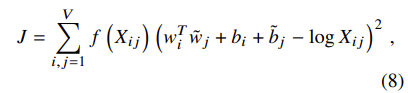

The above formula, taken from GloVe paper, shows the loss function for training. 

Wi and Wj are embedding weights of the center word and context word, and bi and bj are their biases. Xij represents the co-occurrence of the i'th center and the j'th context word.



In [9]:
EMBED_DIM = 10 
#10 is a small dimension size but we have 49 different words in out text
class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)

        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()

    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()

        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j

        return x
glove = GloveModel(vocab_size, EMBED_DIM)
glove.cuda()

GloveModel(
  (wi): Embedding(49, 10)
  (wj): Embedding(49, 10)
  (bi): Embedding(49, 1)
  (bj): Embedding(49, 1)
)

The next step is to define the F(Xij) function, which is given below.

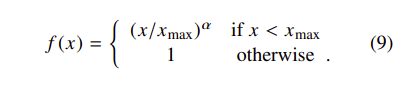

In [10]:
def weight_func(x, x_max, alpha):
        wx = (x/x_max)**alpha
        wx = torch.min(wx, torch.ones_like(wx))
        return wx.cuda()

The GloVe paper uses the AdaGrad optimizer and weighted mean least square error loss function. Let's implement them.

In [11]:
def wmse_loss(weights, inputs, targets):
    loss = weights * F.mse_loss(inputs, targets, reduction='none')
    return torch.mean(loss).cuda()

In [12]:
optimizer = optim.Adagrad(glove.parameters(), lr=0.05)

The next step is training.  In this part, the only difference is that we need to calculate weights before calculating the loss function.  We took alpha and X_max values same as the paper. On the other hand, the number of epochs and batch size are kept relatively low to compensate for our small corpus.

In [13]:
N_EPOCHS = 10 #100
BATCH_SIZE = 2  
X_MAX = 100
ALPHA = 0.75
n_batches = int(len(xij) / BATCH_SIZE)
loss_values = list()

for e in range(1, N_EPOCHS+1):
    batch_i = 0

    for x_ij_, i_idx_, j_idx_ in get_batches(BATCH_SIZE):

        batch_i += 1

        optimizer.zero_grad()

        outputs = glove(i_idx_, j_idx_)
        weights_x = weight_func(x_ij_, X_MAX, ALPHA)
        loss = wmse_loss(weights_x, outputs, torch.log(x_ij_))

        loss.backward()

        optimizer.step()

        loss_values.append(loss.item())

    print("Epoch: {}/{} \t  \t Loss: {}".format(e, N_EPOCHS, np.mean(loss_values[-20:])))  

    print("Saving model...")
    torch.save(glove.state_dict(), "glove_dum.pt")

Epoch: 1/10 	  	 Loss: 0.034731424506753684
Saving model...
Epoch: 2/10 	  	 Loss: 0.018810611119261012
Saving model...
Epoch: 3/10 	  	 Loss: 0.010945464467658894
Saving model...
Epoch: 4/10 	  	 Loss: 0.005324825916113695
Saving model...
Epoch: 5/10 	  	 Loss: 0.005198589579958934
Saving model...
Epoch: 6/10 	  	 Loss: 0.005605658361309907
Saving model...
Epoch: 7/10 	  	 Loss: 0.002177179840145982
Saving model...
Epoch: 8/10 	  	 Loss: 0.003933857056836132
Saving model...
Epoch: 9/10 	  	 Loss: 0.0013171254473490989
Saving model...
Epoch: 10/10 	  	 Loss: 0.001471773607971727
Saving model...


Lastly, as the paper suggested, we will take the average of the two weights and show the visualization of our trained embeddings.

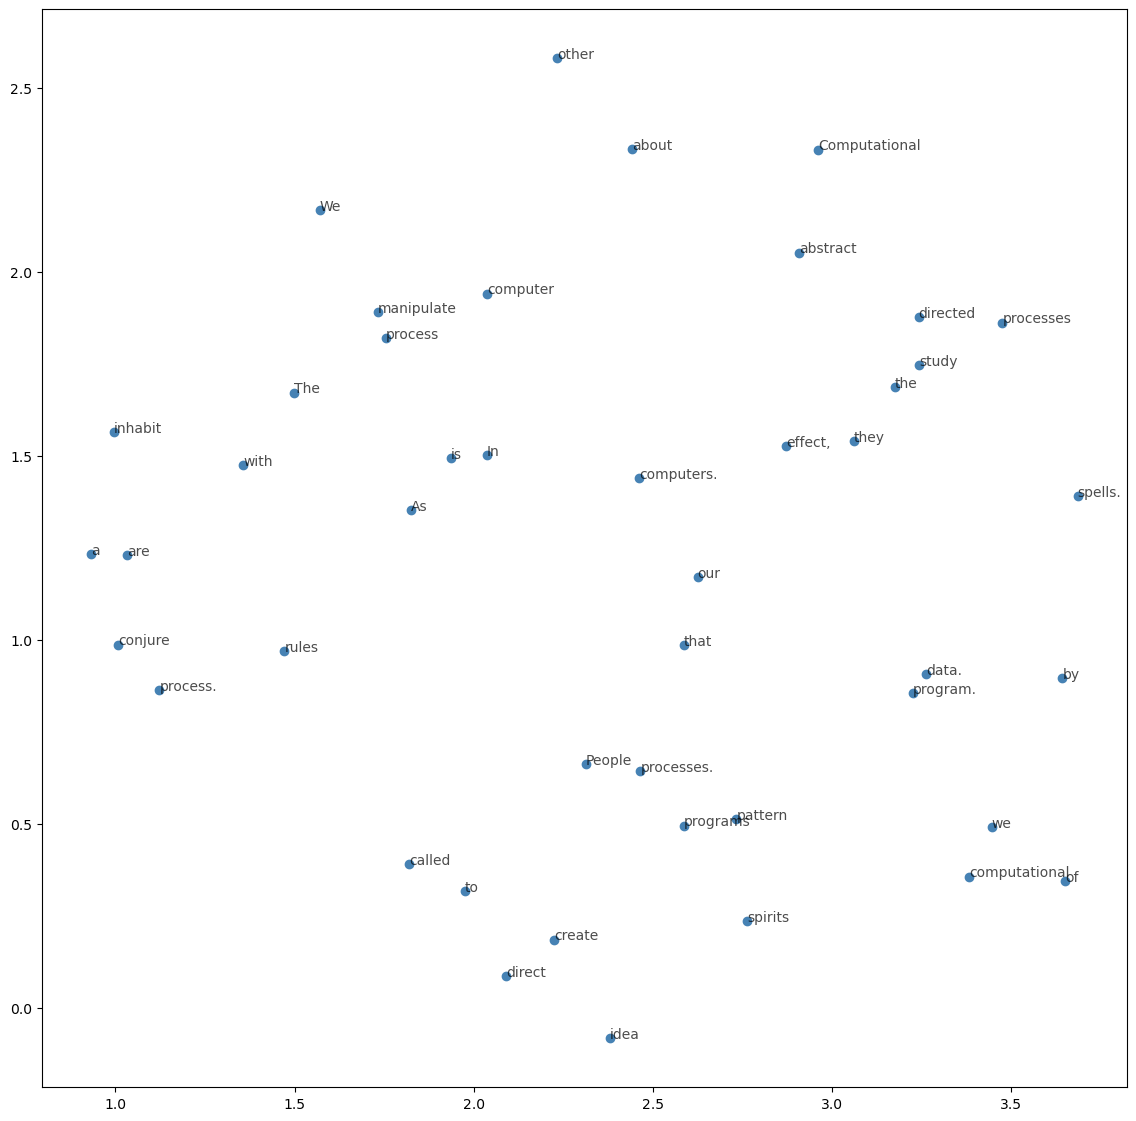

In [14]:
emb_i = glove.wi.weight.cpu().data.numpy()
emb_j = glove.wj.weight.cpu().data.numpy()
emb = emb_i + emb_j
top_k = 45 
tsne = TSNE(metric='cosine', random_state=123)
embed_tsne = tsne.fit_transform(emb[:top_k, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(ix_to_word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)